# Мультиколлинеарность

In [1]:
import pandas as pd
import numpy as np

import statsmodels.formula.api as smf

from statsmodels.graphics.api import plot_corr # визуализация корреляционной матрицы
from statsmodels.iolib.summary2 import summary_params # вывод результатов тестирования
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF # VIF

# настройки визуализации
import matplotlib.pyplot as plt

# Не показывать Warning
import warnings
warnings.simplefilter(action='ignore', category=Warning)

<div style="background-color:Bisque; color:DarkBlue; padding:30px;">

<i><b><span style="color: purple">Мультиколлинеарность</span> </b><br>

Матрицы регрессионного дизайна

$$
\begin{aligned}
	\underset{n\times1}{y}&=\begin{pmatrix} y_1 \\ \vdots \\ y_k\end{pmatrix} &
	\underset{n\times(k+1)}{X}&=\begin{pmatrix} 
		1 & x_{11} & \cdots & x_{1k} \\
		1 & x_{21} & \cdots & x_{2k} \\
		\vdots & \vdots & \ddots & \vdots \\
		1 & x_{n1} & \cdots & x_{nk}\end{pmatrix}
\end{aligned}
$$

__"Чистая" мультиколлинеарность:__ $\det(X^\top X)=0$. В этом случаем регрессия не подгоняется OLS-методом 

__Мультиколлинеарность:__ $\det(X^\top X)\approx0$. Это приводит к "большим" стандартным ошибкам коэффициентам и, как следствие, к "маленьким" t-статистикам и к незначимости коэффициента

__Причина мультиколлинеарности__: высокая слепень зависимости между регрессорами. В частности, сильная корреляция между регрессорами

__Идентификация мультиколлинеарности:__
* корреляционная матрица для регрессоров
* variance inflation factor $VIF=\frac{1}{1-R^2_J}$

**<span style="color:purple">Вывод:</span>** незначимость коэффициента при регрессора может быть вызвана сильной корреляцией этой переменной с остальными

__Два практических кейса:__
* квадрат регрессора
* структурные сдвиги


</div>

Для датасета `sleep75` рассмотрим регрессию `sleep~1+totwrk+age+I(age**2)+smsa+male+south+marr+union`

Подгоним модель и посмотрим значимость коэффициентов

In [2]:
# загрузим данные
df = pd.read_csv('sleep75.csv')

In [3]:
# спецификация модели через формулу
mod = smf.ols(formula='sleep~1+totwrk+age+I(age**2)+smsa+male+south+marr+union', data=df)
# подгонка модели с неробастной оценкой ковариационной матрицы
res = mod.fit()

## Результаты неробастных t-тестов

In [4]:
# проверим значимость коэффициентов используя P-value
summary_params(res).round(4)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,3622.9849,219.6456,16.4947,0.0000,3191.7386,4054.2312
totwrk,-0.1665,0.0182,-9.1276,0.0000,-0.2023,-0.1307
age,-7.0388,11.2319,-0.6267,0.5311,-29.0913,15.0137
I(age ** 2),0.1190,0.1343,0.8864,0.3757,-0.1446,0.3826
smsa,-53.5584,33.1633,-1.6150,0.1068,-118.6704,11.5536
male,85.1892,34.9242,2.4393,0.0150,16.6199,153.7585
south,99.8639,41.8899,2.3840,0.0174,17.6184,182.1095
marr,32.9936,42.0512,0.7846,0.4330,-49.5687,115.5558
union,14.0891,38.1471,0.3693,0.7120,-60.8079,88.9862


## Корреляция регрессоров

In [5]:
# Матрица регрессионного дизайна X (первый столбе состои только из единиц)
# mod.exog
# Для наглядности представим в виде pandsa DataFrame
X = pd.DataFrame(mod.exog, columns=mod.exog_names)
X

,Intercept,totwrk,age,I(age ** 2),smsa,male,south,marr,union
0,1.0,3438.0,32.0,1024.0,0.0,1.0,0.0,1.0,0.0
1,1.0,5020.0,31.0,961.0,0.0,1.0,1.0,0.0,0.0
2,1.0,2815.0,44.0,1936.0,1.0,1.0,0.0,1.0,0.0
3,1.0,3786.0,30.0,900.0,0.0,0.0,0.0,1.0,0.0
4,1.0,2580.0,64.0,4096.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
701,1.0,2026.0,45.0,2025.0,1.0,0.0,0.0,1.0,0.0
702,1.0,675.0,34.0,1156.0,0.0,1.0,0.0,1.0,1.0
703,1.0,1851.0,37.0,1369.0,0.0,0.0,0.0,1.0,0.0
704,1.0,1961.0,54.0,2916.0,0.0,0.0,1.0,1.0,1.0


In [6]:
# Корреляционная матрицы для регрессоров
# Отметим, что нужно исключить первый столбец из единиц
corr_matrix = X.drop(columns='Intercept').corr()
corr_matrix.round(3)

,totwrk,age,I(age ** 2),smsa,male,south,marr,union
totwrk,1.000,-0.050,-0.067,-0.038,0.376,0.051,-0.025,0.002
age,-0.050,1.000,0.992,0.025,0.032,-0.018,0.018,-0.037
I(age ** 2),-0.067,0.992,1.000,0.024,0.026,-0.012,0.008,-0.042
smsa,-0.038,0.025,0.024,1.000,0.007,-0.238,-0.081,-0.039
male,0.376,0.032,0.026,0.007,1.000,-0.034,0.167,0.040
south,0.051,-0.018,-0.012,-0.238,-0.034,1.000,-0.036,-0.047
marr,-0.025,0.018,0.008,-0.081,0.167,-0.036,1.000,-0.005
union,0.002,-0.037,-0.042,-0.039,0.040,-0.047,-0.005,1.000


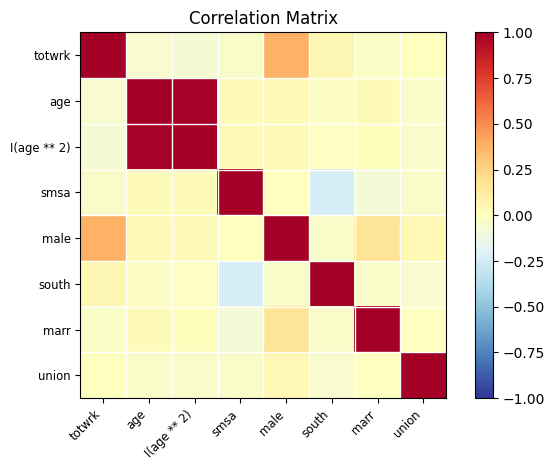

In [7]:
# Визуализация корреляций
plot_corr(corr_matrix, xnames=mod.exog_names[1:], normcolor=True)
plt.show()

## VIF

In [8]:
# имена экзогенных переменных
mod.exog_names

['Intercept',
 'totwrk',
 'age',
 'I(age ** 2)',
 'smsa',
 'male',
 'south',
 'marr',
 'union']

In [9]:
VIF(exog=X, exog_idx=1), VIF(exog=X, exog_idx=2), VIF(exog=X, exog_idx=3), VIF(exog=X, exog_idx=4)

(1.2146479641237498, 66.00983765136014, 66.1675469441062, 1.074503454800783)

In [10]:
# Напечатаем все VIF
for i in np.arange(1, len(mod.exog_names)):
	print(f'VIF({mod.exog_names[i]})={round(VIF(exog=X, exog_idx=i),3)}')

VIF(totwrk)=1.215
VIF(age)=66.01
VIF(I(age ** 2))=66.168
VIF(smsa)=1.075
VIF(male)=1.22
VIF(south)=1.074
VIF(marr)=1.056
VIF(union)=1.011


## Другие способы визуализации корреляционной матрицы

С использованием методы [`heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap) из библиотеки [`seaborn`](https://seaborn.pydata.org/)

<Axes: >

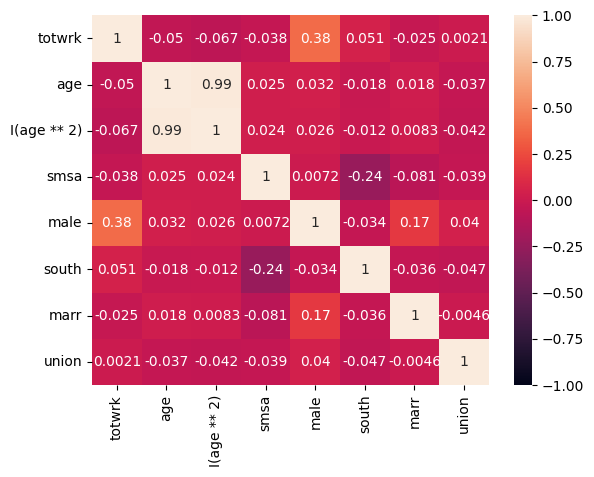

In [13]:
import seaborn as sns

sns.heatmap(corr_matrix, vmax=1, vmin=-1, annot=True)

средствами `pandas`

In [22]:
corr_matrix.style.background_gradient(cmap='coolwarm', vmax=1, vmin=-1).format(precision=2)

,totwrk,age,I(age ** 2),smsa,male,south,marr,union
totwrk,1.00,-0.05,-0.07,-0.04,0.38,0.05,-0.03,0.00
age,-0.05,1.00,0.99,0.02,0.03,-0.02,0.02,-0.04
I(age ** 2),-0.07,0.99,1.00,0.02,0.03,-0.01,0.01,-0.04
smsa,-0.04,0.02,0.02,1.00,0.01,-0.24,-0.08,-0.04
male,0.38,0.03,0.03,0.01,1.00,-0.03,0.17,0.04
south,0.05,-0.02,-0.01,-0.24,-0.03,1.00,-0.04,-0.05
marr,-0.03,0.02,0.01,-0.08,0.17,-0.04,1.00,-0.00
union,0.00,-0.04,-0.04,-0.04,0.04,-0.05,-0.00,1.00


используя `matshow` из `matplotlib`

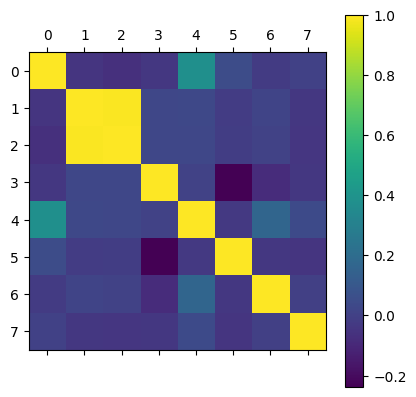

In [24]:
plt.matshow(corr_matrix)
plt.colorbar()
plt.show()